In [1]:
import os
import sys

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import plotly.express as px
from itertools import chain


In [2]:
# change directory to model location
sys.path.append(os.path.abspath('..'))

from susquehanna_model import SusquehannaModel

In [3]:
print(os.getcwd())

/Users/jhkwakkel/Documents/GitHub/MUSEH2O/notebooks


In [8]:
# load variables
varlist = []
variables = []

output_dir = os.path.abspath('../output')
print(output_dir)

for filename in os.listdir(output_dir):
    filepath = os.path.join(output_dir, filename)
    if filename.endswith('variables.csv'):
        varlist.append(filename[:-4])
        df_temp = pd.read_csv(os.path.abspath(filepath), header=None)
        variables.append(df_temp.values.tolist())
print(f"Loaded: {', '.join(varlist)}")
variables = np.asarray(list(chain.from_iterable(variables)))

/Users/jhkwakkel/Documents/GitHub/MUSEH2O/output
Loaded: squared_exponentia_rbf_10_variables


In [9]:
variables[0].shape

(32,)

In [10]:
import rbf_functions

# os.chdir('/Users/jhkwakkel/Documents/GitHub/MUSEH2O')

# def model(RBFType, variables):
# numberOfInput = 4 # (time, storage of Conowingo)
# numberOfOutput = 4  # Atomic, Baltimore,Chester, Downstream:- hydropower, environmental
numberOfRBF = 6  # numberOfInput + 2

n_inputs = 2  # (time, storage of Conowingo)
n_outputs = 4
n_rbfs = n_inputs+2
rbf = rbf_functions.RBF(n_rbfs, n_inputs, n_outputs)

# Initialize model
nobjs = 6
n_years = 1
susquehanna_river = SusquehannaModel(108.5, 505.0, 5, n_years, 
                                    rbf)  # l0, l0_MR, d0, years
# l0 = start level cono, l0_MR = start level muddy run, d0 = startday > friday = 5
susquehanna_river.set_log(True)
# susquehanna_river.setRBF(numberOfRBF, numberOfInput, numberOfOutput, RBFType)

# for solution in algorithm.result:
#     susquehanna_river.evaluate(solution.variables)
for entry in variables:
    susquehanna_river.evaluate(entry)
    
level_CO, level_MR, ratom, rbalt, rches, renv = susquehanna_river.get_log()

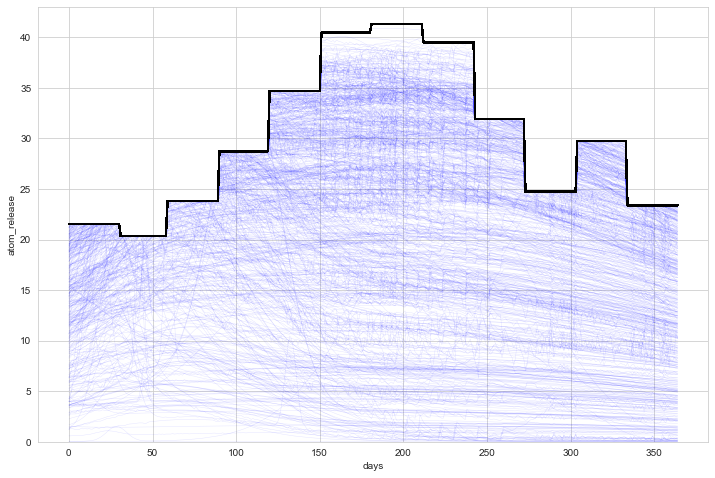

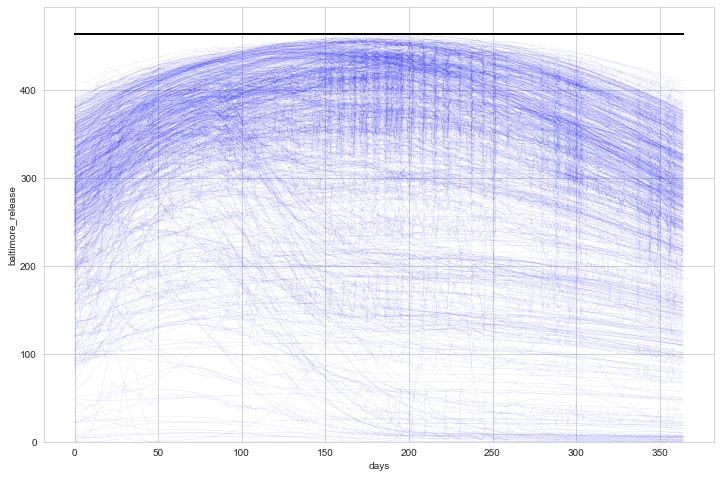

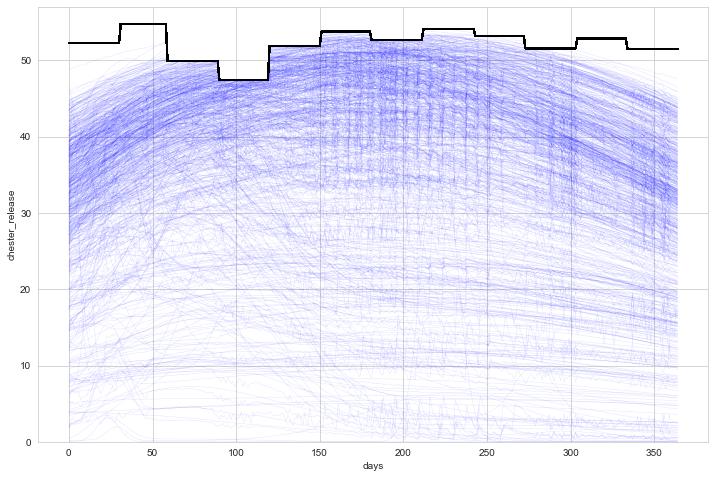

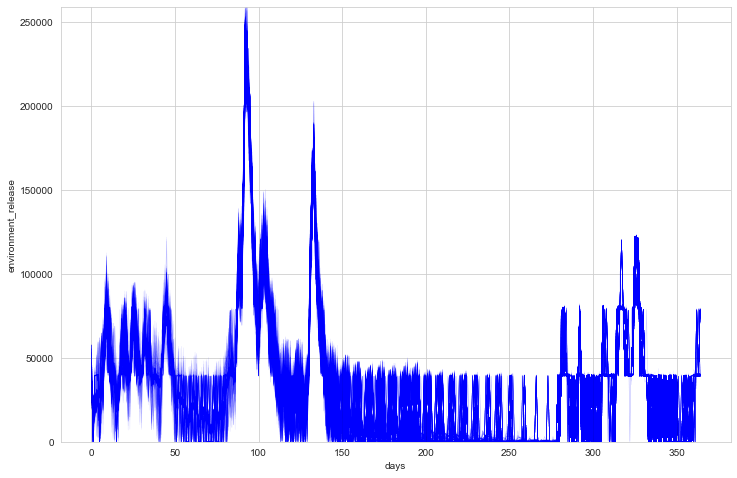

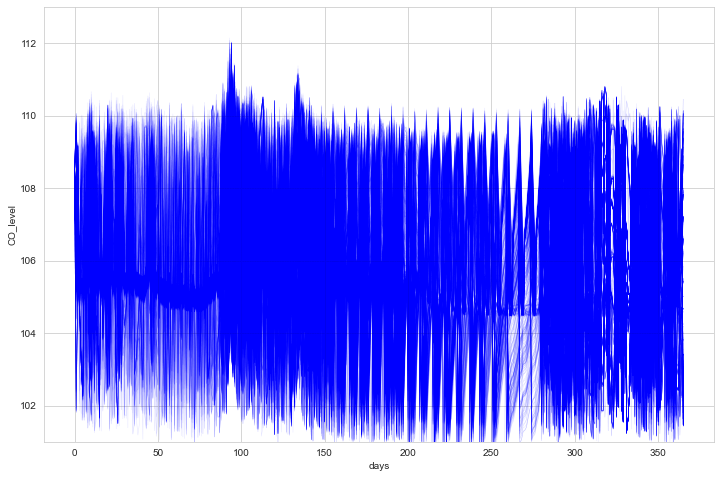

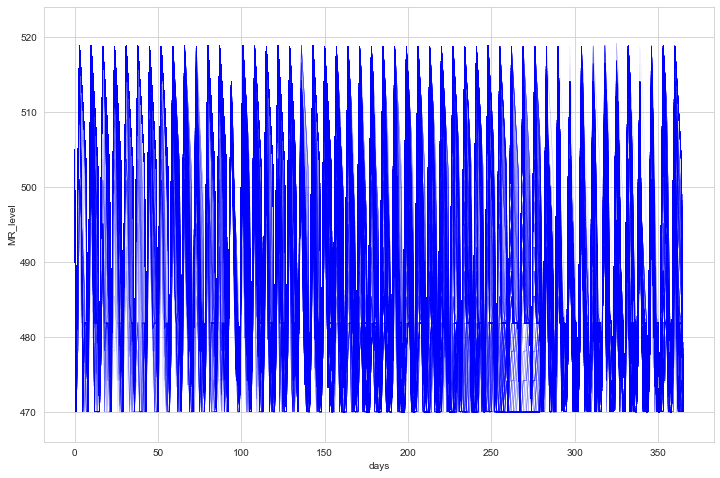

In [11]:
from susquehanna_model import create_path

# load demand

demand_directory = create_path('data1999')

for filename in os.listdir(demand_directory):
    if filename.startswith('w'):
        globals()[f"{filename[:-4]}"] = np.loadtxt(os.path.join(demand_directory, filename))

# plot releases and basins
alpha = 0.1
lw = 0.5
color = "blue"
for release in ratom:
   plot = plt.plot(release, color, linewidth=lw, alpha=alpha)
   plot = plt.plot(wAtomic, "black") 
   plot = plt.xlabel('days')
   plot = plt.ylabel('atom_release')
   plot = plt.ylim((0, 43))
plt.show()

for release in rbalt:
   plot = plt.plot(release, color, linewidth=lw, alpha=alpha)
   plot = plt.plot(wBaltimore, "black")
   plot = plt.xlabel('days')
   plot = plt.ylabel('baltimore_release')
   plot = plt.ylim((0, 495))
plt.show()

for release in rches:
   plot = plt.plot(release, color, linewidth=lw, alpha=alpha)
   plot = plt.plot(wChester, "black")
   plot = plt.xlabel('days')
   plot = plt.ylabel('chester_release')
   plot = plt.ylim((0, 57))
plt.show()

for release in renv:
   plot = plt.plot(release, color, linewidth=lw, alpha=alpha)
   plot = plt.xlabel('days')
   plot = plt.ylabel('environment_release')
   plot = plt.ylim((0, 259000))
plt.show()

for year in level_CO:
   plot = plt.plot(year, color, linewidth=lw, alpha=alpha)
   plot = plt.xlabel('days')
   plot = plt.ylabel('CO_level')
   plot = plt.ylim((101, 113))
plt.show()

for year in level_MR:
   plot = plt.plot(year, color, linewidth=lw, alpha=alpha)
   plot = plt.xlabel('days')
   plot = plt.ylabel('MR_level')
   plot = plt.ylim((466, 524))
plt.show()

In [12]:
# load objectives
objlist = []
objectives = []
for filename in os.listdir('output'):
    if filename.endswith('solution.csv'):
        objlist.append(filename[:-4])
        df_temp = pd.read_csv(f"output/{filename}", header=0)
        objectives.append(df_temp.values.tolist())
print(f"Loaded: {', '.join(objlist)}")
objectives = list(chain.from_iterable(objectives))

FileNotFoundError: [Errno 2] No such file or directory: 'output'

In [ ]:
# parcoords plot objectives
dfl = []
for i in objectives:
    dfl.append(tuple(i))
df = pd.DataFrame(dfl, columns=['Hydropower', 'AtomicPowerplant', 'Baltimore', 'Chester', 'Environment', 'Recreation'])
df = df * -1
colors = []
for i in range(len(df)):
    colors.append(i)
fig = px.parallel_coordinates(df, color="Hydropower")
fig.show()